# Preprocess Images
Normalize the luminance values and resize the images to a standard shape. This is done because the training and test images come in a variety of shapes, sizes, and lighting.

In [1]:
%matplotlib inline

import glob
import os
import re

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image

## Sort numerically
This is not really necessary but when you're exploring it's nice to have the images sorted numerically so that `cat.100.jpg` comes before `cat.1000.jpg`, etc.

In [2]:
def natural_key(string_):
    """
    Define sort key that is integer-aware
    """
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

## Normalize the image luminance
it is common in image analysis to normalize the luminance (brightness) values to have mean 0 and standard deviation 1. We do that here and apply a slight contrast stretch, which also ensures the brightness values stay within the bounds of the image encoding.

The normalization is applied to the luminance, not to the RGB channels individually. We first convert to `YCbCr` space, operate on the `Y` channel, and then convert back to `RGB`.

In [3]:
def norm_image(img):
    """
    Normalize PIL image
    
    Normalizes luminance to (mean,std)=(0,1), and applies a [1%, 99%] contrast stretch
    """
    img_y, img_b, img_r = img.convert('YCbCr').split()
    
    img_y_np = np.asarray(img_y).astype(float)

    img_y_np /= 255
    img_y_np -= img_y_np.mean()
    img_y_np /= img_y_np.std()
    scale = np.max([np.abs(np.percentile(img_y_np, 1.0)),
                    np.abs(np.percentile(img_y_np, 99.0))])
    img_y_np = img_y_np / scale
    img_y_np = np.clip(img_y_np, -1.0, 1.0)
    img_y_np = (img_y_np + 1.0) / 2.0
    
    img_y_np = (img_y_np * 255 + 0.5).astype(np.uint8)

    img_y = Image.fromarray(img_y_np)

    img_ybr = Image.merge('YCbCr', (img_y, img_b, img_r))
    
    img_nrm = img_ybr.convert('RGB')
    
    return img_nrm

## Resize the image
We resize the images to be square with a default side length of 224 to be compatible with models trained on ImageNet. The aspect ratio is preserved and gray bars are added as necessary to make the image square.

In [4]:
def resize_image(img, size):
    """
    Resize PIL image
    
    Resizes image to be square with sidelength size. Pads with black if needed.
    """
    # Resize
    n_x, n_y = img.size
    if n_y > n_x:
        n_y_new = size
        n_x_new = int(size * n_x / n_y + 0.5)
    else:
        n_x_new = size
        n_y_new = int(size * n_y / n_x + 0.5)

    img_res = img.resize((n_x_new, n_y_new), resample=PIL.Image.BICUBIC)

    # Pad the borders to create a square image
    img_pad = Image.new('RGB', (size, size), (128, 128, 128))
    ulc = ((size - n_x_new) // 2, (size - n_y_new) // 2)
    img_pad.paste(img_res, ulc)

    return img_pad

## Accumulate the image names

In [5]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

train_cats = sorted(glob.glob(os.path.join(TRAIN_DIR, 'cat*.jpg')), key=natural_key)
train_dogs = sorted(glob.glob(os.path.join(TRAIN_DIR, 'dog*.jpg')), key=natural_key)
train_all = train_cats + train_dogs

test_all = sorted(glob.glob(os.path.join(TEST_DIR, '*.jpg')), key=natural_key)

## Preprocess a single image
This cell will preprocess a specified or random image and display the before and after versions.

8187


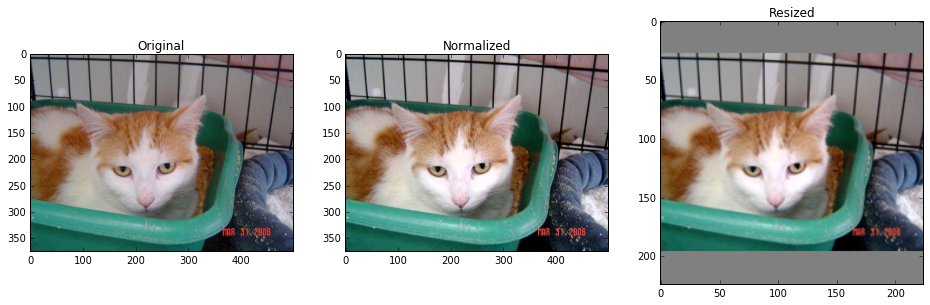

In [6]:
SIZE = 224  # for ImageNet models compatibility

# Read the image
choose_random_image = True
if choose_random_image:
    idx = np.random.randint(0, len(train_all))
else:
    idx = 24486
print(idx)
path = train_all[idx]
img = Image.open(path)

# Normalize it
img_nrm = norm_image(img)


# Resize it
img_res = resize_image(img_nrm, SIZE)

# Show it
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('Original')
plt.imshow(img)

plt.subplot(132)
plt.title('Normalized')
plt.imshow(img_nrm)

plt.subplot(133)
plt.title('Resized')
plt.imshow(img_res)

plt.show()